### Our Work
我们首先是针对苹果，单独的图片进行一系列统一的操作，然后我们再进行识别；
操作包括：
降低亮度
降低太阳亮度的同时增加苹果的红色饱和度



### 美图秀秀操作逻辑
我们做的是降低亮度的操作，究竟有没有效果，我们还不知道！

- 问题一： 绿苹果的识别。我们采用两段掩码，我们需要分别输入红色和绿色的掩码，然后分别识别出两种颜色

- 问题二：太阳光,我们在亮度增强函数里进行了处理

In [73]:
import cv2
import numpy as np

# ========= 🔆 亮度增强函数 =========
def lighting_fast(img, light):
    assert -100 <= light <= 100, "light 范围应为 -100 到 100"
    max_v = 4
    bright = (light / 100.0) / max_v
    mid = 1.0 + max_v * bright
    print('🔧 bright:', bright, '| mid:', mid)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0
    thresh = gray * gray
    t = np.mean(thresh)

    mask = np.where(thresh > t, 255, 0).astype(np.float32)
    brightrate = np.where(mask == 255.0, bright, (1.0 / t * thresh) * bright)
    mask = np.where(mask == 255.0, mid, (mid - 1.0) / t * thresh + 1.0)

    img = img / 255.0
    img = np.power(img, 1.0 / mask[:, :, np.newaxis]) * (1.0 / (1.0 - brightrate[:, :, np.newaxis]))
    img = np.clip(img, 0, 1.0) * 255.0
    return img.astype(np.uint8)

# ========= 🌈 CLAHE =========
def apply_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

# ========= 🎚️ Gamma 校正 =========
def apply_gamma(img, gamma=0.6):
    invGamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** invGamma * 255 for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(img, table)

# ========= 🌫️ 高斯模糊 =========
def apply_gaussian_blur(img, ksize=5):
    return cv2.GaussianBlur(img, (ksize, ksize), 0)

# ========= ✨ 锐化处理 =========
def apply_sharpen(img):
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    return cv2.filter2D(img, -1, kernel)

# ========= 🌗 反色处理 =========
def apply_invert(img):
    return cv2.bitwise_not(img)

def label_image(img, label):
    img_labeled = img.copy()
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img_labeled, label, (10, 30), font, 1.0, (0, 255, 0), 2, cv2.LINE_AA)
    return img_labeled


# ========= 🚀 主程序入口 =========
if __name__ == '__main__':
    image_path = 'Attachment_1/144.jpg'  # ✅ 替换为你本地图片路径
    light = -75                        # ✅ 控制基础亮度 [-100, 100]
    gamma_value = 0.6                  # ✅ Gamma 越小越暗
    blur_size = 5                      # ✅ 高斯模糊核大小，需为奇数

    

    img = cv2.imread(image_path)
    if img is None:
        print("❌ 图像加载失败，请检查路径是否正确：", image_path)
        exit()


    results = []

    # 原图
    results.append(label_image(img, "Original"))

    # 亮度增强
    light_img = lighting_fast(img, light)
    results.append(label_image(light_img, f"Lighting {light}"))

    # CLAHE 对比度增强
    clahe_img = apply_clahe(light_img)
    results.append(label_image(clahe_img, "CLAHE"))

    # Gamma 校正
    gamma_img = apply_gamma(light_img, gamma=gamma_value)
    results.append(label_image(gamma_img, f"Gamma {gamma_value}"))

    # 高斯模糊
    blur_img = apply_gaussian_blur(light_img, ksize=blur_size)
    results.append(label_image(blur_img, f"Blur {blur_size}x{blur_size}"))

    # 锐化处理
    sharpen_img = apply_sharpen(light_img)
    results.append(label_image(sharpen_img, "Sharpen"))

    # 反色处理
    # invert_img = apply_invert(light_img)
    # results.append(label_image(invert_img, "Invert"))


    # 拼接所有图像横向展示（每行最多拼接4张）
    # 统一大小
    img_h, img_w = img.shape[:2]
    n_per_row = 4  # 每行展示几张图

    # Resize 所有图像
    resized_results = [cv2.resize(im, (img_w, img_h)) for im in results]

    # 自动补图（用黑图填充）
    blank = np.zeros_like(resized_results[0])
    while len(resized_results) % n_per_row != 0:
        resized_results.append(blank)

    # 分行拼接
    rows = [
        np.hstack(resized_results[i:i + n_per_row])
        for i in range(0, len(resized_results), n_per_row)
    ]
    combined = np.vstack(rows)


    # 显示处理结果
    cv2.imshow('DIY Image Processing (Original + Effects)', combined)
    print("✅ 图像处理完成，按任意键退出...")
    cv2.waitKey(0)
    cv2.destroyAllWindows()


🔧 bright: -0.1875 | mid: 0.25
✅ 图像处理完成，按任意键退出...


### 现在进行批量处理

In [ ]:
import cv2
import numpy as np
import os
import time

# ========= 🔆 亮度增强函数 =========
def lighting_fast(img, light):
    assert -100 <= light <= 100
    max_v = 4
    bright = (light / 100.0) / max_v
    mid = 1.0 + max_v * bright
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0
    thresh = gray * gray
    t = np.mean(thresh)
    mask = np.where(thresh > t, 255, 0).astype(np.float32)
    brightrate = np.where(mask == 255.0, bright, (1.0 / t * thresh) * bright)
    mask = np.where(mask == 255.0, mid, (mid - 1.0) / t * thresh + 1.0)
    img = img / 255.0
    img = np.power(img, 1.0 / mask[:, :, np.newaxis]) * (1.0 / (1.0 - brightrate[:, :, np.newaxis]))
    img = np.clip(img, 0, 1.0) * 255.0
    return img.astype(np.uint8)

# ========= 🌈 CLAHE =========
def apply_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

# ========= 🎚️ Gamma 校正 =========
def apply_gamma(img, gamma=0.4):
    invGamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** invGamma * 255 for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(img, table)

# ========= 🌫️ 高斯模糊 =========
def apply_gaussian_blur(img, ksize=5):
    return cv2.GaussianBlur(img, (ksize, ksize), 0)

# ========= ✨ 锐化处理 =========
def apply_sharpen(img):
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    return cv2.filter2D(img, -1, kernel)

# ========= 🔴 增强红色区域的饱和度与亮度 =========
def enhance_red_saturation_brightness(img, sat_scale=1.5, val_scale=1.3):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask1 = cv2.inRange(hsv, (0, 100, 50), (10, 255, 255))
    mask2 = cv2.inRange(hsv, (170, 100, 50), (180, 255, 255))
    mask = cv2.bitwise_or(mask1, mask2)

    h, s, v = cv2.split(hsv)
    s = np.where(mask > 0, np.clip(s * sat_scale, 0, 255), s)
    v = np.where(mask > 0, np.clip(v * val_scale, 0, 255), v)

    enhanced_hsv = cv2.merge([h, s.astype(np.uint8), v.astype(np.uint8)])
    enhanced_bgr = cv2.cvtColor(enhanced_hsv, cv2.COLOR_HSV2BGR)
    return enhanced_bgr



######增强红色边界##########
def enhance_red_edges(img, canny_thresh1=50, canny_thresh2=150, dilate_iter=0):  # 💡 默认不膨胀
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # 红色掩模提取
    mask1 = cv2.inRange(hsv, (0, 100, 50), (10, 255, 255))
    mask2 = cv2.inRange(hsv, (170, 100, 50), (180, 255, 255))
    mask = cv2.bitwise_or(mask1, mask2)

    # 提取红色区域
    red_only = cv2.bitwise_and(img, img, mask=mask)
    gray = cv2.cvtColor(red_only, cv2.COLOR_BGR2GRAY)

    # Canny 边缘检测
    edges = cv2.Canny(gray, canny_thresh1, canny_thresh2)

    # （可选）细化边缘，控制粗细
    if dilate_iter > 0:
        kernel = np.ones((3, 3), np.uint8)
        edges = cv2.dilate(edges, kernel, iterations=dilate_iter)

    # 覆盖原图为黑边
    edge_overlay = img.copy()
    alpha = 0.9
    edge_overlay[edges > 0] = (alpha * edge_overlay[edges > 0]).astype(np.uint8)

    return edge_overlay




# ========= 📁 创建输出目录 =========
def create_directory(path):
    if not os.path.exists(path):
        os.makedirs(path)

# ========= 🚀 主程序入口 =========
if __name__ == '__main__':
    input_directory = 'Attachment_1'
    light = -75
    gamma_value = 0.7
    blur_size = 5

    # 每个操作对应的保存文件夹
    operation_dirs = {
    'Original': 'Attachment_2_Original',
    'Lighting': 'Attachment_2_Lighting',
    'CLAHE': 'Attachment_2_CLAHE',
    'Gamma': 'Attachment_2_Gamma',
    'Blur': 'Attachment_2_Blur',
    'Sharpen': 'Attachment_2_Sharpen',
    'RedBoost': 'Attachment_2_RedBoost' ,
    'RedEdge': 'Attachment_2_RedEdge'
    # ✅ 新增红色增强处理
    }

    # 创建所有输出目录
    for path in operation_dirs.values():
        create_directory(path)

    for image_index in range(1, 201):
        input_path = f'{input_directory}/{image_index}.jpg'
        img = cv2.imread(input_path)
        if img is None:
            print(f"⚠️ 跳过第 {image_index} 张图像，未找到 {input_path}")
            continue

        start_time = time.time()

        # 保存原图
        cv2.imwrite(f"{operation_dirs['Original']}/{image_index}.jpg", img)


        
        # Lighting
        light_img = lighting_fast(img, light)
        cv2.imwrite(f"{operation_dirs['Lighting']}/{image_index}.jpg", light_img)

        # CLAHE
        clahe_img = apply_clahe(light_img)
        cv2.imwrite(f"{operation_dirs['CLAHE']}/{image_index}.jpg", clahe_img)

        # Gamma
        gamma_img = apply_gamma(clahe_img, gamma=gamma_value)
        cv2.imwrite(f"{operation_dirs['Gamma']}/{image_index}.jpg", gamma_img)

        # Blur
        blur_img = apply_gaussian_blur(clahe_img, ksize=blur_size)
        cv2.imwrite(f"{operation_dirs['Blur']}/{image_index}.jpg", blur_img)

        # Sharpen
        sharpen_img = apply_sharpen(blur_img)
        cv2.imwrite(f"{operation_dirs['Sharpen']}/{image_index}.jpg", sharpen_img)
        
        
        # RedBoost: 增强红色区域的饱和度与亮度
        redboost_img = enhance_red_saturation_brightness(blur_img, sat_scale=1.3, val_scale=1.3)
        cv2.imwrite(f"{operation_dirs['RedBoost']}/{image_index}.jpg", redboost_img)
        # 红色边界
        redboost_with_edges = enhance_red_edges(redboost_img, dilate_iter=1)

        cv2.imwrite(f"{operation_dirs['RedEdge']}/{image_index}.jpg", redboost_with_edges)


        print(f"✅ 第 {image_index} 张图像处理完成，用时: {time.time() - start_time:.2f}s")


✅ 第 1 张图像处理完成，用时: 0.01s
✅ 第 2 张图像处理完成，用时: 0.01s
✅ 第 3 张图像处理完成，用时: 0.01s
✅ 第 4 张图像处理完成，用时: 0.01s
✅ 第 5 张图像处理完成，用时: 0.01s
✅ 第 6 张图像处理完成，用时: 0.01s
✅ 第 7 张图像处理完成，用时: 0.01s
✅ 第 8 张图像处理完成，用时: 0.01s
✅ 第 9 张图像处理完成，用时: 0.01s
✅ 第 10 张图像处理完成，用时: 0.01s
✅ 第 11 张图像处理完成，用时: 0.01s
✅ 第 12 张图像处理完成，用时: 0.01s
✅ 第 13 张图像处理完成，用时: 0.01s
✅ 第 14 张图像处理完成，用时: 0.01s
✅ 第 15 张图像处理完成，用时: 0.01s
✅ 第 16 张图像处理完成，用时: 0.01s
✅ 第 17 张图像处理完成，用时: 0.01s
✅ 第 18 张图像处理完成，用时: 0.01s
✅ 第 19 张图像处理完成，用时: 0.01s
✅ 第 20 张图像处理完成，用时: 0.01s
✅ 第 21 张图像处理完成，用时: 0.01s
✅ 第 22 张图像处理完成，用时: 0.01s
✅ 第 23 张图像处理完成，用时: 0.01s
✅ 第 24 张图像处理完成，用时: 0.01s
✅ 第 25 张图像处理完成，用时: 0.01s
✅ 第 26 张图像处理完成，用时: 0.01s
✅ 第 27 张图像处理完成，用时: 0.01s
✅ 第 28 张图像处理完成，用时: 0.01s
✅ 第 29 张图像处理完成，用时: 0.01s
✅ 第 30 张图像处理完成，用时: 0.01s
✅ 第 31 张图像处理完成，用时: 0.01s
✅ 第 32 张图像处理完成，用时: 0.01s
✅ 第 33 张图像处理完成，用时: 0.01s
✅ 第 34 张图像处理完成，用时: 0.01s
✅ 第 35 张图像处理完成，用时: 0.01s
✅ 第 36 张图像处理完成，用时: 0.01s
✅ 第 37 张图像处理完成，用时: 0.01s
✅ 第 38 张图像处理完成，用时: 0.01s
✅ 第 39 张图像处理完成，用时: 0.01s
✅ 第 40 张图像处理完成，用时: 0.01s
✅ 第 41 张图

### 分水岭

In [100]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

# ========= 🚪 创建输出目录 =========
def create_directory(path):
    if not os.path.exists(path):
        os.makedirs(path)

# ========= 📖 读取图片 =========
def ReadImg(image_path):
    return cv2.imread(image_path, 1)

# ========= 🔬 高斯滤波 =========
def GausBlur(src):
    return cv2.GaussianBlur(src, (5, 5), 1.5)

# ========= 🧼 开运算 =========
def open_mor(img):
    kernel = np.ones((5, 5), np.uint8)
    return cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

# ========= 🔴 检测红色区域（HSV更鲁棒） =========
def detect_red_objects_hsv_lab(src):
    hsv = cv2.cvtColor(src, cv2.COLOR_BGR2HSV)
    lab = cv2.cvtColor(src, cv2.COLOR_BGR2Lab)

    # 原来
    mask_hsv1 = cv2.inRange(hsv, (0, 100, 50), (10, 255, 255))
    mask_hsv2 = cv2.inRange(hsv, (170, 70, 50), (180, 255, 255))

    # ✅ 放宽 Hue 范围到 (0~15, 165~180)，放宽 Saturation 最低值
    # mask_hsv1 = cv2.inRange(hsv, (0, 80, 30), (15, 255, 255))
    # mask_hsv2 = cv2.inRange(hsv, (165, 80, 30), (180, 255, 255))
    mask_hsv = cv2.bitwise_or(mask_hsv1, mask_hsv2)

    # LAB 中 a 通道 > 150 是偏红的区域
    a_channel = lab[:, :, 1]
    mask_lab = cv2.inRange(a_channel, 90, 200)

    # 联合掩模
    mask = cv2.bitwise_and(mask_hsv, mask_lab)
    red_objects = cv2.bitwise_and(src, src, mask=mask)

    return red_objects

# ========= ✏️ 拟合轮廓并标记 =========
def draw_shape(open_img, src):
    contours, _ = cv2.findContours(open_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    apple_count = 0
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 50:
            continue
        (x, y), radius = cv2.minEnclosingCircle(cnt)
        center = (int(x), int(y))
        radius = int(radius)
        cv2.drawContours(src, [cnt], 0, (0, 255, 0), 2)
        cv2.circle(src, center, radius, (0, 0, 255), 2)
        apple_count += 1
    return src, apple_count

# ========= 💧 Watershed 分割 =========
def watershed_segmentation(open_img, src):
    dist_transform = cv2.distanceTransform(open_img, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.4 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    sure_bg = cv2.dilate(open_img, None, iterations=3)
    unknown = cv2.subtract(sure_bg, sure_fg)
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0
    cv2.watershed(src, markers)
    return src

# ========= 🚀 批量处理多个预处理目录 =========
input_base_dirs = [
    'Attachment_2_Original',
    'Attachment_2_Lighting',
    'Attachment_2_CLAHE',
    'Attachment_2_Gamma',
    'Attachment_2_Blur',
    'Attachment_2_Sharpen',
    'Attachment_2_RedBoost',
    'Attachment_2_RedEdge'
]

summary = {}

for input_dir in input_base_dirs:
    label = input_dir.split("_")[-1]
    output_dir = f'Attachment_3_{label}'
    create_directory(output_dir)

    counts = []

    for i in tqdm(range(1, 201), desc=f"Processing {label}"):
        input_path = f'{input_dir}/{i}.jpg'
        output_path = f'{output_dir}/{i}_detected.jpg'
        src = ReadImg(input_path)
        if src is None:
            counts.append(None)
            continue

        gaus_img = GausBlur(src)
        red_objects_img = detect_red_objects_hsv_lab(gaus_img)
        gray_img = cv2.cvtColor(red_objects_img, cv2.COLOR_BGR2GRAY)
        _, thres_img = cv2.threshold(gray_img, 1, 255, cv2.THRESH_BINARY)
        open_img = open_mor(thres_img)
        open_img = cv2.medianBlur(open_img, 5)  # 去掉椒盐噪声
        # Watershed 分割（不返回新标记图）
        segmented_img = watershed_segmentation(open_img.copy(), src.copy())

        # 拟合并画轮廓
        result_img, apple_count = draw_shape(open_img, segmented_img)
        counts.append(apple_count)

        # 保存图片
        cv2.imwrite(output_path, result_img)

    summary[label] = counts

# 写入 CSV 文件
df = pd.DataFrame(summary)
df.index = np.arange(1, 201)
csv_path = 'apple_counts_summary_v2_v2.csv'
df.to_csv(csv_path)

print("保存完成:", csv_path)

Processing RedEdge: 100%|██████████| 200/200 [00:00<00:00, 461.60it/s]

保存完成: apple_counts_summary_v2_v2.csv


In [101]:
### 对比结果
import os
import cv2
import numpy as np
from tqdm import tqdm

# 拼接函数：横向拼接（或可修改为网格）
def concat_images(image_list, resize_dim=(300, 300)):
    resized_images = [cv2.resize(img, resize_dim) for img in image_list]
    return cv2.hconcat(resized_images)

# 设置目录与标签
base_output_folders = [
    'Attachment_3_Original',
    'Attachment_3_Lighting',
    'Attachment_3_CLAHE',
    'Attachment_3_Gamma',
    'Attachment_3_Blur',
    'Attachment_3_Sharpen',
    'Attachment_3_RedBoost',
    'Attachment_3_RedEdge'
]
labels = [folder.split('_')[-1] for folder in base_output_folders]

# 创建保存对比图目录
compare_output_dir = 'Comparison_Plots'
os.makedirs(compare_output_dir, exist_ok=True)

# 开始对比每张图
for i in tqdm(range(1, 201), desc="Saving comparison images"):
    images = []
    valid = True
    for folder in base_output_folders:
        img_path = f'{folder}/{i}_detected.jpg'
        img = cv2.imread(img_path)
        if img is None:
            valid = False
            break
        images.append(img)
    if not valid:
        continue
    concat_img = concat_images(images)
    save_path = f"{compare_output_dir}/{i}_comparison.jpg"
    cv2.imwrite(save_path, concat_img)

print("所有对比图保存完成 ✅")



Saving comparison images: 100%|██████████| 200/200 [00:01<00:00, 127.25it/s]

所有对比图保存完成 ✅


### 圈出苹果+显示坐标

保存图像到: abcde/output_image_1.png


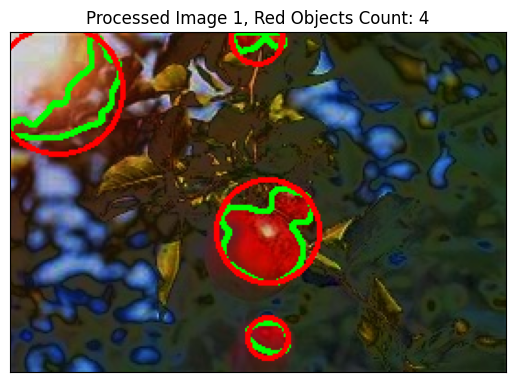

保存图像到: abcde/output_image_2.png


保存图像到: abcde/output_image_3.png


保存图像到: abcde/output_image_4.png


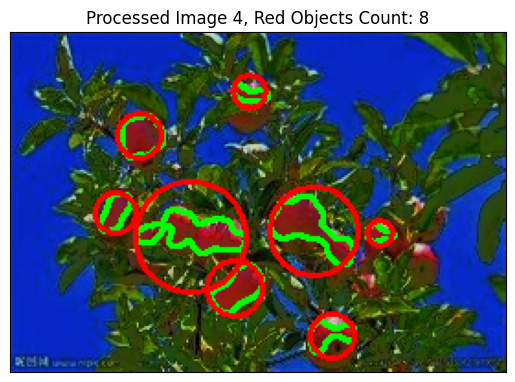

保存图像到: abcde/output_image_5.png


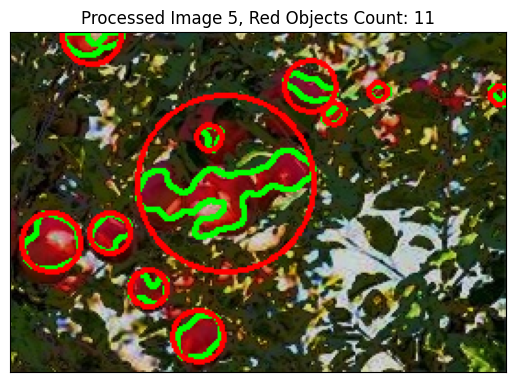

保存图像到: abcde/output_image_6.png


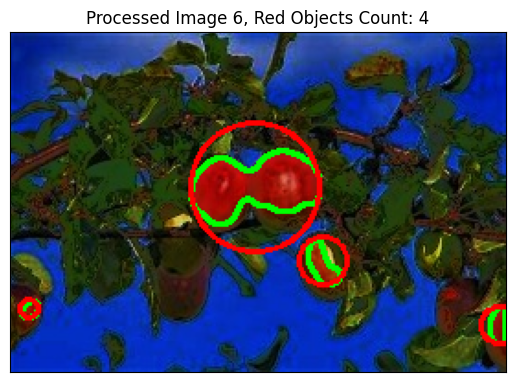

保存图像到: abcde/output_image_7.png


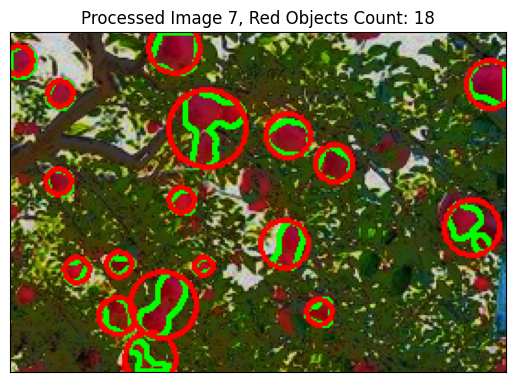

保存图像到: abcde/output_image_8.png


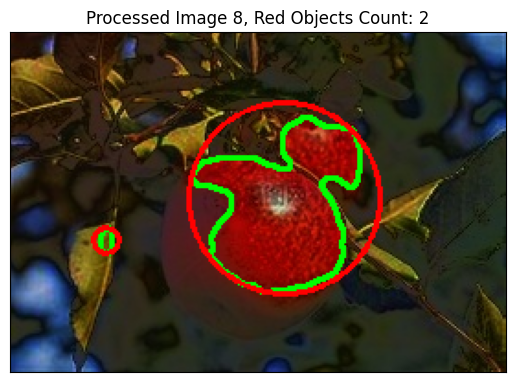

保存图像到: abcde/output_image_9.png


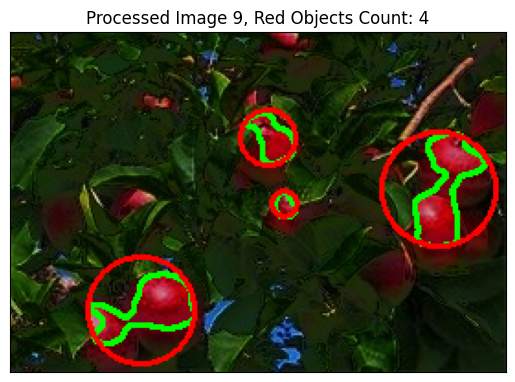

保存图像到: abcde/output_image_10.png


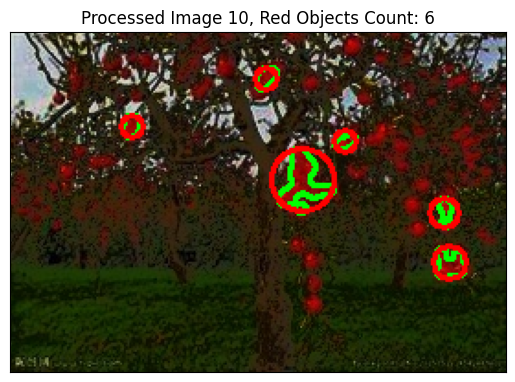

保存图像到: abcde/output_image_11.png


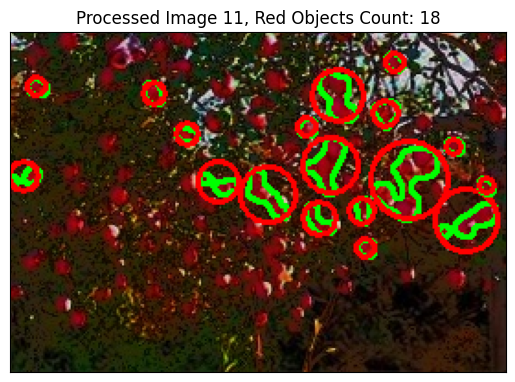

保存图像到: abcde/output_image_12.png


保存图像到: abcde/output_image_13.png


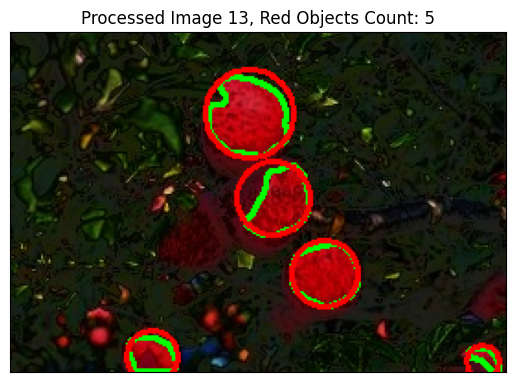

保存图像到: abcde/output_image_14.png


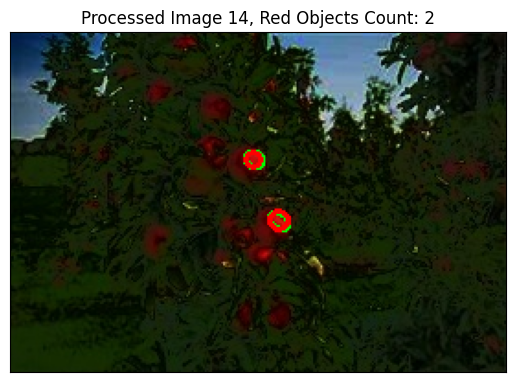

保存图像到: abcde/output_image_15.png


保存图像到: abcde/output_image_16.png


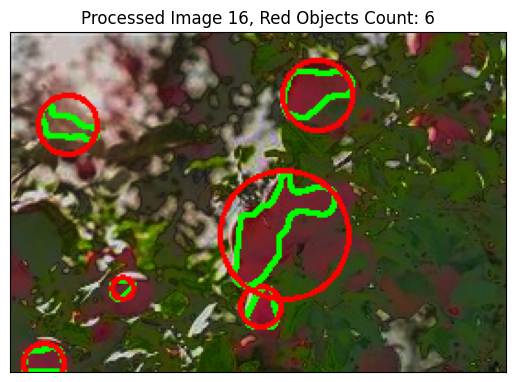

保存图像到: abcde/output_image_17.png


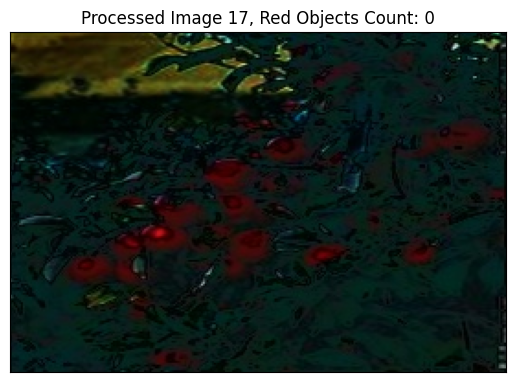

保存图像到: abcde/output_image_18.png


保存图像到: abcde/output_image_19.png


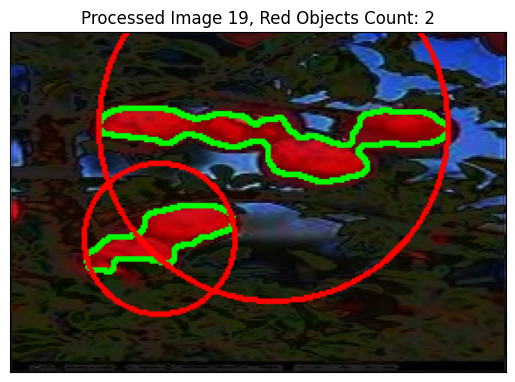

保存图像到: abcde/output_image_20.png


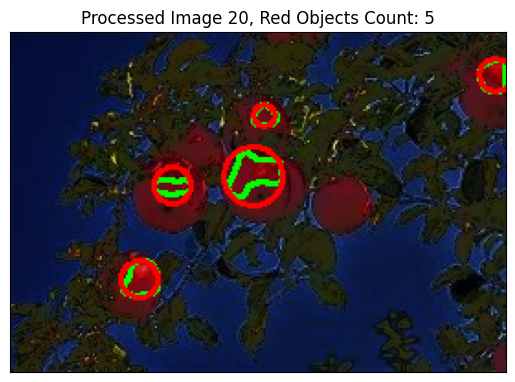

保存图像到: abcde/output_image_21.png


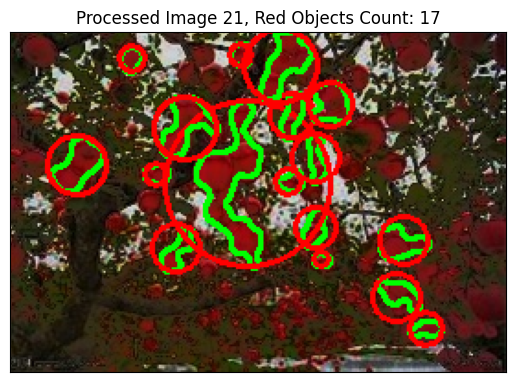

保存图像到: abcde/output_image_22.png


KeyboardInterrupt: 

In [50]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# 读取图片
def ReadImg(image_path):
    img = cv2.imread(image_path, 1)
    return img

# 高斯滤波
def GausBlur(src):
    dst = cv2.GaussianBlur(src, (5, 5), 1.5)
    return dst

# 开运算（替代 open_mor）
def open_mor(img):
    kernel = np.ones((5, 5), np.uint8)
    result = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    return result

# 红色对象检测
def detect_red_objects(src):
    # 设定红色阈值范围
    lower_red = np.array([0, 0, 100])
    upper_red = np.array([100, 100, 255])

    # 根据阈值构建掩模
    mask = cv2.inRange(src, lower_red, upper_red)

    # 使用掩模提取红色对象
    red_objects = cv2.bitwise_and(src, src, mask=mask)

    return red_objects

# 轮廓拟合
def draw_shape(open_img, src):
    contours, hierarchy = cv2.findContours(open_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    apple_count = 0
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 50:  # 假设红色对象的最小面积为100
            # 获取圆心和半径
            (x, y), radius = cv2.minEnclosingCircle(cnt)
            center = (int(x), int(y))
            radius = int(radius)

            # 描绘绿色的边框线
            cv2.drawContours(src, [cnt], 0, (0, 255, 0), 2)

            # 绘制圆形
            cv2.circle(src, center, radius, (0, 0, 255), 2)

            apple_count += 1

    return src, apple_count

# Watershed 分割
def watershed_segmentation(open_img, src):
    # 使用距离变换和阈值分割进行分水岭算法
    dist_transform = cv2.distanceTransform(open_img, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)

    # 找到未知区域
    sure_bg = cv2.dilate(open_img, None, iterations=3)
    sure_bg = 255 - sure_bg

    # 标记未知区域
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[open_img == 0] = 0

    # 应用分水岭算法
    cv2.watershed(src, markers)

    return src

# 处理所有图像
for i in range(1, 201):  # 假设图像编号从1到200
    image_path = f'Attachment_2/{i}_processed.jpg'
    src = ReadImg(image_path)
    gaus_img = GausBlur(src)
    red_objects_img = detect_red_objects(gaus_img)
    gray_img = cv2.cvtColor(red_objects_img, cv2.COLOR_BGR2GRAY)
    _, thres_img = cv2.threshold(gray_img, 1, 255, cv2.THRESH_BINARY)
    open_img = open_mor(thres_img)
    open_img = cv2.medianBlur(open_img, 5)  # 去掉椒盐噪声
    result_img, apple_count = draw_shape(open_img, src)

    # Watershed 分割
    result_img = watershed_segmentation(open_img, result_img)

    # 上下翻转图像，不影响Y轴
    flipped_img = np.flipud(result_img)

    # 处理所有图像
    output_folder = 'abcde'
    os.makedirs(output_folder, exist_ok=True)
    # 创建带有坐标轴的图像
    plt.imshow(cv2.cvtColor(flipped_img, cv2.COLOR_BGR2RGB))
    plt.gca().invert_yaxis()  # 反转Y轴
    plt.xticks([])  # 移除X轴坐标标签
    plt.yticks([])  # 移除Y轴坐标标签
    plt.title(f'Processed Image {i}, Red Objects Count: {apple_count}')

    # 将带有坐标轴的图像保存到文件
    output_path = os.path.join(output_folder, f'output_image_{i}.png')
    plt.savefig(output_path)
    plt.clf()  # 清除当前图像，以便下一次使用

    print(f'保存图像到: {output_path}')

    # 显示翻转后的图像
    plt.imshow(cv2.cvtColor(flipped_img, cv2.COLOR_BGR2RGB))
    plt.gca().invert_yaxis()  # 反转Y轴
    plt.xticks([])  # 移除X轴坐标标签
    plt.yticks([])  # 移除Y轴坐标标签
    plt.title(f'Processed Image {i}, Red Objects Count: {apple_count}')
    plt.show()

### 蒙特卡洛算法估计苹果质量和体积


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# 读取图片
def ReadImg(image_path):
    img = cv2.imread(image_path, 1)
    return img

# 高斯滤波
def GausBlur(src):
    dst = cv2.GaussianBlur(src, (5, 5), 1.5)
    return dst

# 开运算（替代 open_mor）
def open_mor(img):
    kernel = np.ones((5, 5), np.uint8)
    result = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    return result

# 红色对象检测
def detect_red_objects(src):
    # 设定红色阈值范围
    lower_red = np.array([0, 0, 100])
    upper_red = np.array([100, 100, 255])

    # 根据阈值构建掩模
    mask = cv2.inRange(src, lower_red, upper_red)

    # 使用掩模提取红色对象
    red_objects = cv2.bitwise_and(src, src, mask=mask)

    return red_objects

# 轮廓拟合
def process_and_save_image(open_img, src, image_path, i):
    contours, hierarchy = cv2.findContours(open_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    apple_count = 0
    with open('apple_coordinates.txt', 'a') as file:
        for cnt in contours:
            area = cv2.contourArea(cnt)
            if area > 50:  # 假设红色对象的最小面积为100
                # 获取圆心和半径
                (x, y), radius = cv2.minEnclosingCircle(cnt)
                center = (int(x), int(y))
                radius = int(radius)

                # 在文件中写入坐标
                file.write(f'({x}, {y})\n')
                apple_count += 1

    # 绘制图像
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 50:  # 假设红色对象的最小面积为100
            # 获取圆心和半径
            (x, y), radius = cv2.minEnclosingCircle(cnt)
            center = (int(x), int(y))
            radius = int(radius)

            # 绘制圆形
            cv2.circle(src, center, radius, (0, 0, 255), 2)



# 创建结果图像保存文件夹
output_folder = 'Processed_Images'
os.makedirs(output_folder, exist_ok=True)

# 处理所有图像
for i in range(1, 201):  # 假设图像编号从1到200
    image_path = f'Attachment_2/{i}_processed.jpg'
    src = ReadImg(image_path)
    gaus_img = GausBlur(src)
    red_objects_img = detect_red_objects(gaus_img)
    gray_img = cv2.cvtColor(red_objects_img, cv2.COLOR_BGR2GRAY)
    _, thres_img = cv2.threshold(gray_img, 1, 255, cv2.THRESH_BINARY)
    open_img = open_mor(thres_img)
    apple_count = process_and_save_image(open_img, src, image_path, i)

    # 保存结果图像到新的文件夹
    output_path = os.path.join(output_folder, f'Processed_Image_{i}.jpg')
    cv2.imwrite(output_path, src)

    print(f'Processed Image {i}, Red Objects Count: {apple_count}')

In [ ]:
### 散点绘图

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# 读取自己的图片作为背景
custom_background_img = np.array(Image.open("/Users/zhangying/Processed_Image_2.jpg"))
# 创建一个函数来生成图像并添加随机点
def generate_image(base_image, num_points):
    img = np.copy(base_image)  # 创建基于基础图片的副本
    height, width = img.shape

    # 在图像上随机生成指定数量的点
    for _ in range(num_points):
        x, y = np.random.randint(0, width), np.random.randint(0, height)
        img[y, x] = 0  # 在随机位置添加黑色点

    return img

# 生成四个不同数量随机点的图片
num_points_list = [100, 500, 1500, 3000]
images = [generate_image(background_img, num_points) for num_points in num_points_list]

plt.figure(figsize=(8, 8))

for i in range(4):
    plt.subplot(2, 2, i + 1)
    
    # 获取随机点的坐标
    coords = np.argwhere(images[i] == 0)
    
    # 绘制散点图，设置颜色为绿色
    plt.scatter(coords[:, 1], coords[:, 0], c='green', s=5)  # y坐标在前，x坐标在后
    # 显示自定义背景图片
    plt.imshow(custom_background_img, cmap='gray', alpha=1)  # 设置alpha值透明度
    plt.title(f'{num_points_list[i]} Random Points')
    plt.axis('off')  # 关闭坐标轴

plt.tight_layout()
plt.show()

### 成熟度检测

In [ ]:
### 成熟度检测
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import numpy as np

#2类分类
num_classes = 2
nppath = "./"

#加载数据
x_train = np.load(nppath + "x_train.npy")
# x_test = np.load(nppath + "x_train.npy")
x_test = np.load(nppath + "x_test.npy")
y_train = np.load(nppath + "y_train.npy")
# y_test = np.load(nppath + "y_train.npy")
y_test = np.load(nppath + "y_test.npy")

x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

# 此优化器对本实验不适用
#opt = keras.optimizers.rmsprop(lr=0.001, decay=1e-6)

# train the model using RMSprop
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# hist = model.fit(x_train, y_train, epochs=100, shuffle=True)
# model.save("./cnnmodel.h5")
#
# # evaluate
# loss, accuracy = model.evaluate(x_test, y_test)
# print(loss, accuracy)

import matplotlib.pyplot as plt

def plot_loss(history):
    # 提取训练集和验证集的损失值
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # 设置图表标题和标签
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # 绘制训练集和验证集的损失曲线
    plt.plot(train_loss, label='Training Loss', color='blue')
    plt.plot(val_loss, label='Validation Loss', color='orange')

    # 添加图例
    plt.legend()

    # 显示图表
    plt.show()


def plot_acc(history):
    # 提取训练集和验证集的准确率
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # 设置图表标题和标签
    plt.title('Model Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Acc')

    # 绘制训练集和验证集的损失曲线
    plt.plot(train_accuracy, label='Training Acc', color='red')
    plt.plot(val_accuracy, label='Validation Acc', color='yellow')

    # 添加图例
    plt.legend()

    # 显示图表
    plt.show()

# 训练模型并记录训练历史
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=16, verbose=0)

# 绘制损失曲线
plot_loss(history)
plot_acc(history)

### 训练模型，看Attachment 3 的苹果是否预测准确


In [ ]:
import torch
from torchvision import models, transforms
from torchvision.models import resnet50
from PIL import Image
import os
import re
import matplotlib.pyplot as plt

def extract_numbers_in_brackets(input_string):
    # 使用正则表达式匹配括号内的数字
    pattern = r'\((\d+)\)'
    matches = re.findall(pattern, input_string)

    # 返回匹配到的数字列表
    return [int(match) for match in matches][0]


# 加载预训练的ResNet-50模型
model = resnet50()
model_path = './checkpoint/fruit_reg.pth'
# model.load_state_dict(torch.load(model_path))
model = torch.load(model_path)
# print(net)
model.eval()  # 将模型设置为评估模式，这是因为在推理阶段不需要梯度

# 定义数据转换
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet-50的输入尺寸为224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 获取指定路径下的所有文件和文件夹
directory = '/Users/wuguobin/Documents/model/Attachment/Attachment 3/'
files = os.listdir(directory)

appleID = []
# 遍历文件和文件夹
for file in files:
    # 获取文件或文件夹的完整路径
    image_path = os.path.join(directory, file)

    # 加载图像并进行预测
    # image_path = '/Users/wuguobin/Documents/model/Attachment/Attachment 3/Fruit (75).jpg'
    image = Image.open(image_path)
    input_tensor = transform(image)
    input_batch = input_tensor.unsqueeze(0)  # 添加一个维度表示批次大小

    # 使用模型进行预测
    with torch.no_grad():
        output = model(input_batch)

    # 加载类标签文件
    # with open('imagenet_classes.txt', 'r') as f:
    #     classes = [line.strip() for line in f.readlines()]

    # 获取预测结果
    _, predicted_idx = torch.max(output, 1)
    # print(predicted_idx)
    # predicted_label = classes[predicted_idx.item()]
    # print(f'Predicted label: {predicted_label}')

    # 如果是苹果，记录苹果ID
    if predicted_idx==0:
        num = extract_numbers_in_brackets(image_path)
        print(num)
        appleID.append(num)

print(len(appleID))

# 绘制直方图
plt.hist(appleID, bins=50, color='skyblue', edgecolor='black')  # bins为柱子数量
plt.xlabel('ID numbers of all apple images')
plt.ylabel('freq')
plt.title('distribution histogram')
plt.show()

### 识别出青苹果和红苹果


In [ ]:
import cv2
import numpy as np
import glob
import os

# 创建文件夹以存储处理后的图像
output_folder = "output_images"
os.makedirs(output_folder, exist_ok=True)

def process_image(image_path, output_folder):
    image = cv2.imread(image_path)

    # 以下是图像处理的代码...

    # 保存中间和最终图像
    image_name = os.path.splitext(os.path.basename(image_path))[0]

    # 保存苹果图像
    cv2.imwrite(os.path.join(output_folder, f"{image_name}_apples.jpg"), apples)

    # 保存掩膜图像
    cv2.imwrite(os.path.join(output_folder, f"{image_name}_mask.jpg"), mask)

    # 保存高斯模糊图像
    cv2.imwrite(os.path.join(output_folder, f"{image_name}_GaussianBlur.jpg"), mask)

    # 保存腐蚀和膨胀图像
    cv2.imwrite(os.path.join(output_folder, f"{image_name}_erode_dilate.jpg"), mask)

    # 保存绘制轮廓后的图像
    cv2.imwrite(os.path.join(output_folder, f"{image_name}_draw_img.jpg"), draw_img)

    print(f"处理并保存完成：{image_name}")

# 读取图像
image_paths = glob.glob('Attachment_1/*.jpg')  # 修改为你的图像文件夹路径

for image_path in image_paths:
    process_image(image_path, output_folder)

### 苹果面积估计

In [ ]:
#这个是仅仅打印的，看看能不能用吧
import random
import cv2
import numpy as np
import glob

def is_point_inside_polygon(x, y, polygon):
    n = len(polygon)
    inside = False

    p1x, p1y = polygon[0][0]
    for i in range(n + 1):
        p2x, p2y = polygon[i % n][0]
        if y > min(p1y, p2y) and y <= max(p1y, p2y) and x <= max(p1x, p2x):
            if p1y != p2y:
                xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                if p1x == p2x or x <= xinters:
                    inside = not inside
        p1x, p1y = p2x, p2y

    return inside

def monte_carlo_pi(num, polygon, x1, y1, x2, y2):
    points_inside_circle = 0

    for _ in range(num):
        x = random.uniform(x1, x2)
        y = random.uniform(y1, y2)

        if is_point_inside_polygon(x, y, polygon):
            points_inside_circle += 1

    w = abs(x1 - x2)
    h = abs(y1 - y2)
    pi_estimate = points_inside_circle / num * w * h
    return pi_estimate

# 获取图像文件路径列表
image_folder_path = '/Users/zhangying/iCloud Drive (Archive) - 2/Desktop/Andrea/Academic 学术/建模资料/亚太地区A题解题/Attachment 1'  # 修改为你的图像文件夹路径
image_paths = glob.glob(image_folder_path + '/*.jpg')

for image_path in image_paths:
    image = cv2.imread(image_path)

    lower_green = np.array([40, 40, 40])
    upper_green = np.array([80, 255, 255])

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask_green = cv2.inRange(hsv, lower_green, upper_green)

    kernel = np.ones((5, 5), np.uint8)
    mask_green = cv2.morphologyEx(mask_green, cv2.MORPH_CLOSE, kernel)
    mask_green = cv2.morphologyEx(mask_green, cv2.MORPH_OPEN, kernel)
    mask_apple = cv2.bitwise_not(mask_green)
    apples = cv2.bitwise_and(image, image, mask=mask_apple)

    hsv = cv2.cvtColor(apples, cv2.COLOR_BGR2HSV)

    lower_red1 = np.array([0, 100, 50])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 100, 100])
    upper_red2 = np.array([180, 255, 255])

    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    mask = cv2.bitwise_or(mask1, mask2)

    mask = cv2.GaussianBlur(mask, (5, 5), 0)

    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.erode(mask, kernel, iterations=2)
    mask = cv2.dilate(mask, kernel, iterations=2)

    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    all_area_estimate = 0
    for i in range(len(contours)):
        cnt = contours[i]
        x, y, w, h = cv2.boundingRect(cnt)
        area_estimate = monte_carlo_pi(1000, cnt, x, y, x+w, y+h)
        all_area_estimate += area_estimate

    image_name = image_path.split('/')[-1].split('.')[0]
    print(f"图像 {image_name} 的苹果总面积估算值为：{all_area_estimate}")

In [ ]:
#现在试试用Excel
import random
import cv2
import numpy as np
import glob
import pandas as pd

def is_point_inside_polygon(x, y, polygon):
    n = len(polygon)
    inside = False

    p1x, p1y = polygon[0][0]
    for i in range(n + 1):
        p2x, p2y = polygon[i % n][0]
        if y > min(p1y, p2y) and y <= max(p1y, p2y) and x <= max(p1x, p2x):
            if p1y != p2y:
                xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                if p1x == p2x or x <= xinters:
                    inside = not inside
        p1x, p1y = p2x, p2y

    return inside

def monte_carlo_pi(num, polygon, x1, y1, x2, y2):
    points_inside_circle = 0

    for _ in range(num):
        x = random.uniform(x1, x2)
        y = random.uniform(y1, y2)

        if is_point_inside_polygon(x, y, polygon):
            points_inside_circle += 1

    w = abs(x1 - x2)
    h = abs(y1 - y2)
    pi_estimate = points_inside_circle / num * w * h
    return pi_estimate

# 获取图像文件路径列表
image_folder_path = '/Users/zhangying/iCloud Drive (Archive) - 2/Desktop/Andrea/Academic 学术/建模资料/亚太地区A题解题/Attachment 1'  # 修改为你的图像文件夹路径
image_paths = glob.glob(image_folder_path + '/*.jpg')
# 创建一个空的列表，用于存储结果
result_list = []

for image_path in image_paths:
    image = cv2.imread(image_path)

    lower_green = np.array([40, 40, 40])
    upper_green = np.array([80, 255, 255])

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask_green = cv2.inRange(hsv, lower_green, upper_green)

    kernel = np.ones((5, 5), np.uint8)
    mask_green = cv2.morphologyEx(mask_green, cv2.MORPH_CLOSE, kernel)
    mask_green = cv2.morphologyEx(mask_green, cv2.MORPH_OPEN, kernel)
    mask_apple = cv2.bitwise_not(mask_green)
    apples = cv2.bitwise_and(image, image, mask=mask_apple)

    hsv = cv2.cvtColor(apples, cv2.COLOR_BGR2HSV)

    lower_red1 = np.array([0, 100, 150])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([160, 100, 100])
    upper_red2 = np.array([180, 255, 255])

    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    mask = cv2.bitwise_or(mask1, mask2)

    mask = cv2.GaussianBlur(mask, (5, 5), 0)

    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.erode(mask, kernel, iterations=2)
    mask = cv2.dilate(mask, kernel, iterations=2)

    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    all_area_estimate = 0
    for i in range(len(contours)):
        cnt = contours[i]
        x, y, w, h = cv2.boundingRect(cnt)
        area_estimate = monte_carlo_pi(1000, cnt, x, y, x+w, y+h)
        all_area_estimate += area_estimate

    image_name = image_path.split('/')[-1].split('.')[0]
    num_of_apples = len(contours)
 # 将结果添加到列表中
    result_list.append({'Image': image_name,
                        'Number of Apples': num_of_apples,
                        'Total Area Estimate': all_area_estimate})

# 将列表转换为DataFrame
result_df = pd.DataFrame(result_list)

# 将DataFrame写入EXCEL文件
output_csv_path = '蒙特卡洛.xlsx'  # 修改为你的输 出EXCEL文件路径
result_df.to_excel(output_csv_path, index=False)

print(f"结果已写入EXCEL文件：{output_csv_path}")